In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Lambda, Flatten, Dense, Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.convolutional import Cropping2D
import cv2
import os
import csv
import sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD, Adam
import h5py

%matplotlib inline

Using TensorFlow backend.


This image is: <class 'numpy.ndarray'> with dimensions: (160, 320, 3)


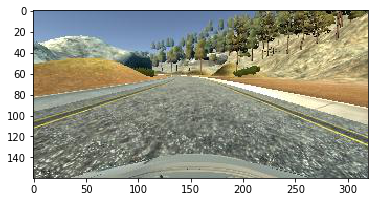

In [2]:
#reading in an image
image = mpimg.imread('../IMG/center_2017_10_15_20_35_25_295.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)

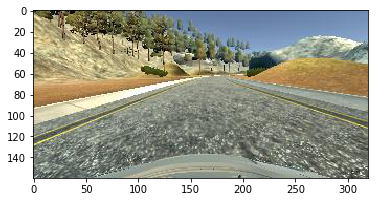

In [3]:
image_flipped = np.fliplr(image)
plt.imshow(image_flipped)

In [4]:
# I may not need this function since Keras has one.
def crop_topAndBottom(img,top=55,bottom=15):
    y, _, _ = img.shape
    return img[top:y-bottom]

(90, 320, 3)


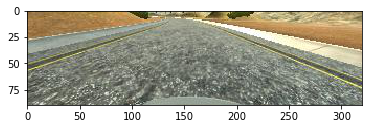

In [5]:
cropimg = crop_topAndBottom(image)
plt.imshow(cropimg)
print(cropimg.shape)

In [6]:
samples = []
with open('../driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)

train_samples, validation_samples = train_test_split(samples, test_size=0.2)

def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                name = '../IMG/'+batch_sample[0].split('/')[-1]
                center_image = cv2.imread(name)
                center_angle = float(batch_sample[3])
                images.append(center_image)
                angles.append(center_angle)

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)

# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

#ch, row, col = 3, 80, 320  # Trimmed image format
model = Sequential()
model.add(Cropping2D(cropping=((50,20), (0, 0)), input_shape=(160,320,3)))
model.add(Lambda(lambda x: (x / 255.0) - 0.5))#, input_shape=(160,320,3)))

model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='linear'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='linear'))
          
# Preprocess incoming data, centered around zero with small standard deviation 
model.compile(loss='mse', optimizer='adam')


In [7]:
model.fit_generator(train_generator, samples_per_epoch= len(train_samples),
                    validation_data=validation_generator, nb_val_samples=len(validation_samples), nb_epoch=2)


C:\Users\hchan\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
C:\Users\hchan\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., epochs=2, validation_data=<generator..., validation_steps=2656, steps_per_epoch=10624)`
  


Epoch 1/2
 2984/10624 [=======>......................] - ETA: 2540s - loss: 0.0744

KeyboardInterrupt: 

In [ ]:

model.save('model.h5')